In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt
import os
import seaborn as sns
from pyswarms.single.global_best import GlobalBestPSO

2023-08-28 11:36:34.850950: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Número de filas y columnas: (2557, 1) 

Tipo de datos:
 Load    int64
dtype: object 

Head:
                   Load
Date                  
2015-01-01  5686686080
2015-01-02  6752007030
2015-01-03  6605796020
2015-01-04  6273091530
2015-01-05  6760770300 



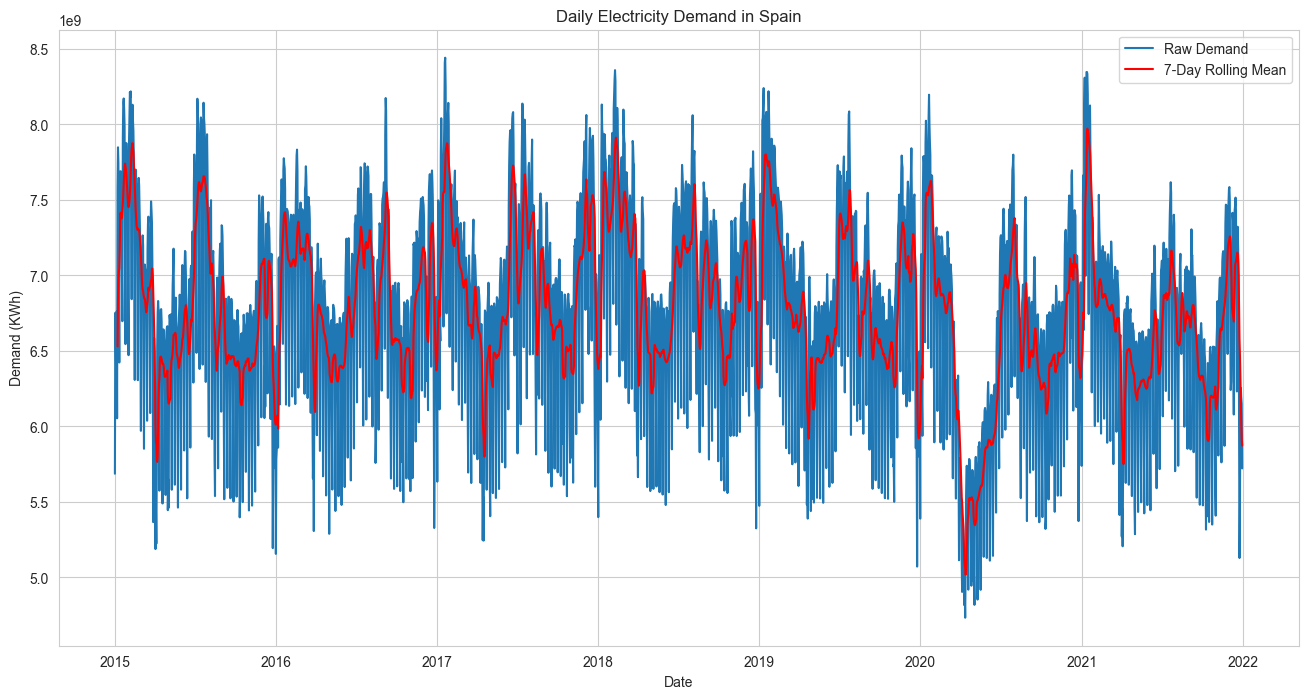

In [2]:
# Load dataset
path = os.getcwd()
fichero_DemandaDiaria = os.path.join(path, 'DemandaDiaria_KWh_2015-2021.csv')

# Read the data
data = pd.read_csv(fichero_DemandaDiaria, sep=";")
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

# Check the data
print("Número de filas y columnas:", data.shape, "\n")
print("Tipo de datos:\n", data.dtypes, "\n")
print("Head:\n", data.head(), "\n")

# Graph the data
sns.set_style("whitegrid")
rolling_mean = data['Load'].rolling(window=7).mean()
plt.figure(figsize=(16, 8))
plt.title('Daily Electricity Demand in Spain')
plt.xlabel('Date')
plt.ylabel('Demand (KWh)')
plt.plot(data.index, data['Load'], label='Raw Demand')
plt.plot(data.index, rolling_mean, color='red', label='7-Day Rolling Mean')
plt.legend(loc='best')
plt.show()

In [3]:
# Standardize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Load'].values.reshape(-1, 1))

# Split the data into training and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]

# Create sequences of length 'sequence_length' to use as input data
def create_sequences(dataset, sequence_length_scope):
    X, y = [], []
    # Iterate over the dataset and create sequences of length 'sequence_length'
    for i in range(len(dataset) - sequence_length_scope):
        # Add a sequence of length 'sequence_length' to X
        X.append(dataset[i:i + sequence_length_scope, 0])
        # Add the next data point after each sequence of length 'sequence_length' to y
        y.append(dataset[i + sequence_length_scope, 0])
    # Convert list to array
    return np.array(X), np.array(y)

sequence_length = 10  # Length of the sequence for each input point
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Check the shape of the training sequences
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2035, 10)
y_train shape: (2035,)
X_test shape: (502, 10)
y_test shape: (502,)


In [4]:
# Reshape de los datos para LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [5]:
def fitness_function(params):    
    units1 = params[:, 0].astype(int)
    units2 = params[:, 1].astype(int)

    train_rmse = []
    test_rmse = []
    train_mae = []
    test_mae = []
    train_mrae = []
    test_mrae = []

    for i in range(len(units1)):  # Utiliza units1.shape[0] para iterar sobre los elementos de units1
        print('Iteration: ', i, ' of ', len(units1))
        unit1_value = units1[i]
        unit2_value = units2[i]
        
        _model = Sequential()
        _model.add(Conv1D(filters=unit1_value, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
        _model.add(MaxPooling1D(pool_size=2))
        _model.add(Conv1D(filters=unit2_value, kernel_size=3, activation='relu'))
        _model.add(MaxPooling1D(pool_size=2))
        _model.add(Flatten())
        _model.add(Dense(units=1))
        
        _model.compile(optimizer='adam', loss='mean_squared_error')
        _model.fit(X_train, y_train, epochs=20, batch_size=15, verbose=0)

        # Realizar predicciones
        train_pred = _model.predict(X_train)
        test_pred = _model.predict(X_test)
        train_predictions = scaler.inverse_transform(train_pred.reshape(-1, 1))
        test_predictions = scaler.inverse_transform(test_pred.reshape(-1, 1))
        y_train_unscaled = scaler.inverse_transform( y_train.reshape(-1,1) )
        y_test_unscaled = scaler.inverse_transform( y_test.reshape(-1,1) )

        # Calcular métricas de rendimiento
        train_rmse =  np.append( train_rmse, np.sqrt(np.mean((y_train_unscaled - train_predictions) ** 2 )) )
        test_rmse = np.append( test_rmse, np.sqrt(np.mean((y_test_unscaled - test_predictions) ** 2 )) )
        train_mae = np.append ( train_mae, np.mean(np.abs(y_train_unscaled - train_predictions) ) )
        test_mae = np.append( test_mae, np.mean(np.abs(y_test_unscaled - test_predictions)) )
        mean_load = data['Load'].mean()
        train_mrae = np.append( train_mrae, np.mean(np.abs((y_train_unscaled - train_predictions) / mean_load)) )
        test_mrae = np.append( test_mrae, np.mean(np.abs((y_test_unscaled - test_predictions) / mean_load) ) )
        
    return test_mrae

In [6]:
# Optimizar los hiperparámetros con PSO
lb = [30, 30]
ub = [50, 50]
bounds = (lb, ub)

optimizer = GlobalBestPSO(n_particles=10, dimensions=2, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9}, bounds=bounds)
best_params = optimizer.optimize(fitness_function, iters=10)

# Obtener el número de unidades óptimo para las capas de LSTM (deben ser enteros)
best_units = int(best_params[1][0]), int(best_params[1][1])
print("Best Units:", best_units)

# Crear el modelo LSTM con los mejores hiperparámetros encontrados
model = Sequential()

# Primera capa CNN (filters -> Optimizado con PSO, número de filtros, kernel_size -> Tamaño de la ventana, activation -> Función de activación, input_shape -> Forma de los datos de entrada)
model.add(Conv1D(filters=best_units[0], kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
# Capa de pooling (reducción de dimensionalidad)
model.add(MaxPooling1D(pool_size=2))

# Segunda capa CNN (filters -> Optimizado con PSO, número de filtros, kernel_size -> Tamaño de la ventana, activation -> Función de activación)
model.add(Conv1D(filters=best_units[1], kernel_size=3, activation='relu'))
# Capa de pooling (reducción de dimensionalidad)
model.add(MaxPooling1D(pool_size=2))

# Capa de aplanamiento (flatten)
model.add(Flatten())

# Capa densa (units: Número de neuronas, activation: Función de activación)
model.add(Dense(units=1))

# Compilar el modelo (optimizer: Algoritmo de optimización, loss: Función de pérdida)
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0) 

2023-08-28 11:36:40,394 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|                                         |0/10

Iteration:  0  of  10
16/16 [==============================] - 0s 932us/step
Iteration:  1  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  2  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  3  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  4  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  5  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  6  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  7  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  8  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  9  of  10
16/16 [==============================] - 0s 1ms/step


pyswarms.single.global_best:  10%|██▎                    |1/10, best_cost=0.0246

Iteration:  0  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  1  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  2  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  3  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  4  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  5  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  6  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  7  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  8  of  10
16/16 [==============================] - 0s 2ms/step
Iteration:  9  of  10
16/16 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  20%|████▌                  |2/10, best_cost=0.0246

Iteration:  0  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  1  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  2  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  3  of  10
16/16 [==============================] - 0s 927us/step
Iteration:  4  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  5  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  6  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  7  of  10
16/16 [==============================] - 0s 956us/step
Iteration:  8  of  10
16/16 [==============================] - 0s 942us/step
Iteration:  9  of  10
16/16 [==============================] - 0s 1ms/step


pyswarms.single.global_best:  30%|██████▉                |3/10, best_cost=0.0236

Iteration:  0  of  10
16/16 [==============================] - 0s 945us/step
Iteration:  1  of  10
16/16 [==============================] - 0s 966us/step
Iteration:  2  of  10
16/16 [==============================] - 0s 968us/step
Iteration:  3  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  4  of  10
16/16 [==============================] - 0s 964us/step
Iteration:  5  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  6  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  7  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  8  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  9  of  10
16/16 [==============================] - 0s 999us/step


pyswarms.single.global_best:  40%|█████████▏             |4/10, best_cost=0.0235

Iteration:  0  of  10
16/16 [==============================] - 0s 946us/step
Iteration:  1  of  10
16/16 [==============================] - 0s 2ms/step
Iteration:  2  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  3  of  10
16/16 [==============================] - 0s 989us/step
Iteration:  4  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  5  of  10
16/16 [==============================] - 0s 2ms/step
Iteration:  6  of  10
16/16 [==============================] - 0s 2ms/step
Iteration:  7  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  8  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  9  of  10
16/16 [==============================] - 0s 1ms/step


pyswarms.single.global_best:  50%|███████████▌           |5/10, best_cost=0.0235

Iteration:  0  of  10
16/16 [==============================] - 0s 956us/step
Iteration:  1  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  2  of  10
16/16 [==============================] - 0s 986us/step
Iteration:  3  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  4  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  5  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  6  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  7  of  10
16/16 [==============================] - 0s 983us/step
Iteration:  8  of  10
16/16 [==============================] - 0s 993us/step
Iteration:  9  of  10
16/16 [==============================] - 0s 1ms/step


pyswarms.single.global_best:  60%|█████████████▊         |6/10, best_cost=0.0235

Iteration:  0  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  1  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  2  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  3  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  4  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  5  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  6  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  7  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  8  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  9  of  10
16/16 [==============================] - 0s 993us/step


pyswarms.single.global_best:  70%|████████████████       |7/10, best_cost=0.0235

Iteration:  0  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  1  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  2  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  3  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  4  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  5  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  6  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  7  of  10
16/16 [==============================] - 0s 2ms/step
Iteration:  8  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  9  of  10
16/16 [==============================] - 0s 1ms/step


pyswarms.single.global_best:  80%|██████████████████▍    |8/10, best_cost=0.0235

Iteration:  0  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  1  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  2  of  10
16/16 [==============================] - 0s 2ms/step
Iteration:  3  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  4  of  10
16/16 [==============================] - 0s 2ms/step
Iteration:  5  of  10
16/16 [==============================] - 0s 2ms/step
Iteration:  6  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  7  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  8  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  9  of  10
16/16 [==============================] - 0s 1ms/step


pyswarms.single.global_best:  90%|████████████████████▋  |9/10, best_cost=0.0235

Iteration:  0  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  1  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  2  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  3  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  4  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  5  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  6  of  10
16/16 [==============================] - 0s 2ms/step
Iteration:  7  of  10
16/16 [==============================] - 0s 1ms/step
Iteration:  8  of  10
16/16 [==============================] - 0s 2ms/step
Iteration:  9  of  10
16/16 [==============================] - 0s 2ms/step


pyswarms.single.global_best: 100%|██████████████████████|10/10, best_cost=0.0235
2023-08-28 11:44:28,921 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.023475739572762708, best pos: [42.52347249 42.49880887]


Best Units: (42, 42)


In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Get predictions
y_pred = model.predict(X_test)

# Invert the normalization for y_pred and y_test
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(y_test_original, y_pred_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

# Calculate MRAE (Mean Absolute Percentage Error)
mrae = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

# Print metrics
print('MAE: {:,.2f}'.format(mae))
print('RMSE: {:,.2f}'.format(rmse))
print('MRAE: {:,.2f} %'.format(mrae))

16/16 [==============================] - 0s 2ms/step
MAE: 157,089,325.72
RMSE: 248,525,464.88
MRAE: 2.40 %


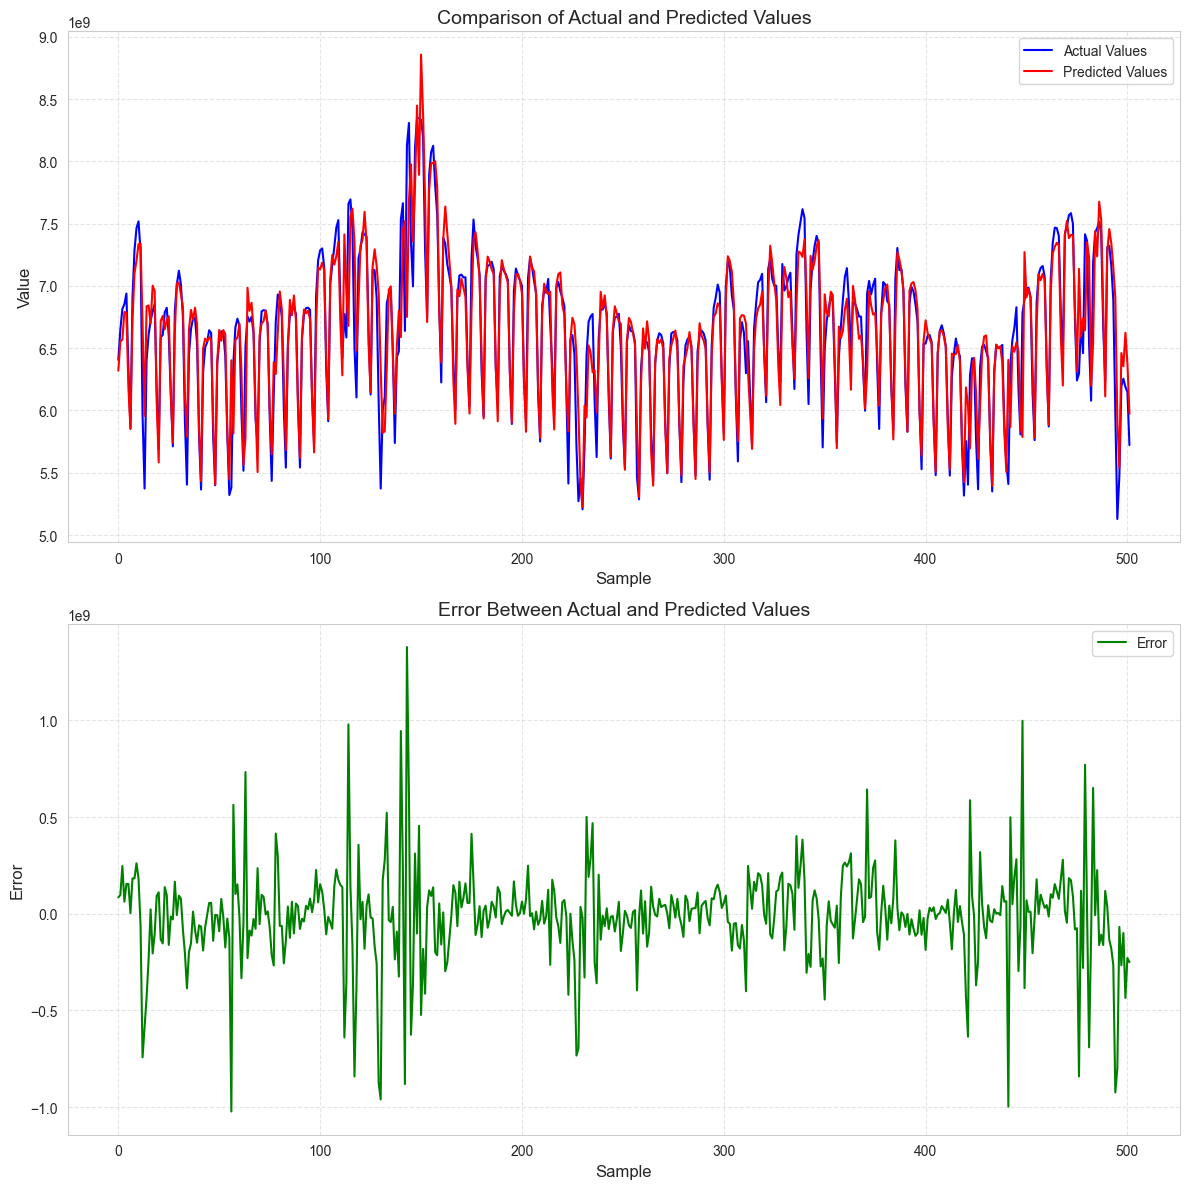

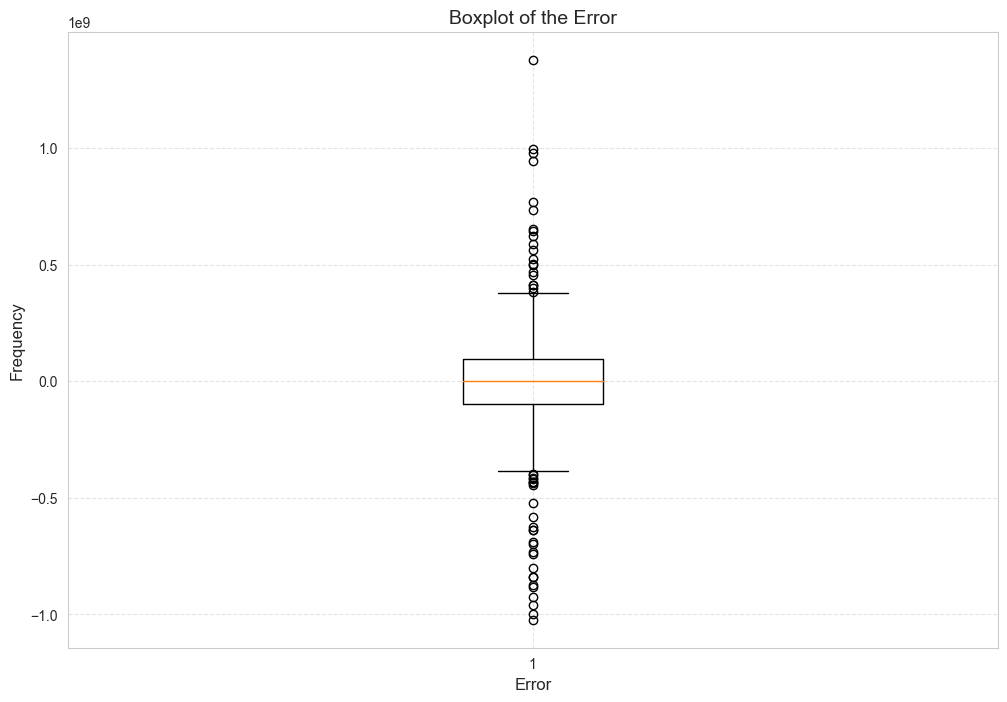

In [8]:
# Calculate the error between actual and predicted values
error = y_test_original - y_pred_original

# Create a figure and a set of subplots (2 subplots)
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot the actual vs predicted values in the first subplot
axes[0].plot(y_test_original, label='Actual Values', color='blue')
axes[0].plot(y_pred_original, label='Predicted Values', color='red')
axes[0].set_xlabel('Sample', fontsize=12)
axes[0].set_ylabel('Value', fontsize=12)
axes[0].set_title('Comparison of Actual and Predicted Values', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plot the error in the second subplot
axes[1].plot(error, label='Error', color='green')
axes[1].set_xlabel('Sample', fontsize=12)
axes[1].set_ylabel('Error', fontsize=12)
axes[1].set_title('Error Between Actual and Predicted Values', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.5)

# Show the plots
plt.tight_layout()
plt.show()

# Boxplot of the error
plt.figure(figsize=(12, 8))
plt.boxplot(error)
plt.xlabel('Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Boxplot of the Error', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()